In [16]:
from preprocessing import DataLoader
from matplotlib import pyplot as plt

# 数据读取

In [17]:
data_loader_a = DataLoader('data/Data A-Crew.csv', 'data/Data A-Flight.csv')

In [21]:
data_loader_a.dump_data()

AttributeError: 'DataLoader' object has no attribute 'dump_data'

# 模型建立与求解

In [9]:
import gurobipy as gp
from gurobipy import *

## 优化目标①

In [10]:
m=gp.Model('m1')

z=m.addVars(data_loader_a.F,vtype=gp.GRB.BINARY,name='z')
x_ikdh=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='x_dh')
x_ikfo=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='x_fo')
x_ikcap=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='x_cap')

r_iksta=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='r_iksta')
r_jkfin=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='r_jkfin')

y_ijk=m.addVars(data_loader_a.F,data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='y_ijk')


m.ModelSense=GRB.MINIMIZE

m.setObjective(-z.sum())
# m.setObjective(x_ikdh.sum())
# m.setObjective(gp.quicksum(x_ikfo[i,k] for i in data_loader_a.F for k in data_loader_a.C2))

#m.setObjectiveN(-z.sum(),index = 0,weight =0.8)
#m.setObjectiveN(x_ikdh.sum(),index=1,weight=0.2)
#m.setObjectiveN(gp.quicksum(x_ikfo[i,k] for i in data_loader_a.F for k in data_loader_a.C2),index=2,weight=0.05)


M=10000
#对X的约束
m.addConstrs(x_ikfo[i,k]==0 for i in data_loader_a.F for k in data_loader_a.C1 )
m.addConstrs(x_ikcap[i,k]==0 for i in data_loader_a.F for k in data_loader_a.C3 )
m.addConstrs(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]<=1 for i in data_loader_a.F for k in data_loader_a.C)

#对Z的约束
m.addConstrs(gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for k in data_loader_a.C)<=M*(z[i]) for i in data_loader_a.F)
m.addConstrs(x_ikcap.sum(i,'*')== z[i] for i in data_loader_a.F )
m.addConstrs(x_ikfo.sum(i,'*')== z[i] for i in data_loader_a.F )
m.addConstrs(M*z[j]>=gp.quicksum(x_ikcap[j,k]+x_ikfo[j,k]+x_ikdh[j,k] for k in data_loader_a.C) for j in data_loader_a.F)

#对Y的约束
m.addConstrs(y_ijk[i,j,k]==0 for i,j in data_loader_a.FF for k in data_loader_a.C)
#m.addConstrs(gp.quicksum(y_ijk[i,j,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)
#m.addConstrs(gp.quicksum(y_ijk[j,i,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)

#对roaster周期的约束
m.addConstrs(r_jkfin[j,k]== 0 for j in data_loader_a.nonF_arrive_base[0] for k in data_loader_a.C)
m.addConstrs(r_iksta[i,k]== 0 for i in data_loader_a.nonF_leave_base[0] for k in data_loader_a.C)

m.addConstrs(gp.quicksum(r_iksta[i,k] for i in data_loader_a.F_leave_base[0] )<=1  for k in data_loader_a.C)
m.addConstrs(gp.quicksum(r_jkfin[j,k] for j in data_loader_a.F_arrive_base[0] )-gp.quicksum(r_iksta[i,k] for i in data_loader_a.F_leave_base[0] ) == 0 for k in data_loader_a.C)

#第一问中航班对应周期的约束
m.addConstrs(1-(y_ijk.sum(i,'*',k)+r_iksta[i,k]+r_jkfin[i,k])<=M*(1-(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])) for i in data_loader_a.F for k in data_loader_a.C)
m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k]-(y_ijk.sum('*',i,k)+r_iksta[i,k]) == 0 for i in data_loader_a.F for k in data_loader_a.C)

m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a.F for k in data_loader_a.C)
m.addConstrs(y_ijk.sum('*',i,k)+r_iksta[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a.F for k in data_loader_a.C)

#多目标优化
# m.addConstr(z.sum()==206)
# m.addConstr(x_ikdh.sum()==8)

m.update()
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 790007 rows, 912992 columns and 5334386 nonzeros
Model fingerprint: 0x8766957d
Variable types: 0 continuous, 912992 integer (912992 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 0.0000000
Presolve removed 770786 rows and 767578 columns
Presolve time: 2.39s
Presolved: 19221 rows, 145414 columns, 577408 nonzeros
Variable types: 0 continuous, 145414 integer (145414 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15093   -3.1336139e+01   0.000000e+00   2.638588e+05      5s
   34283   -6.0886684e+01   0.000000e+00   2.054291e+06     10s
   50388 

## 优化目标④

In [11]:
m=gp.Model('m1')

z=m.addVars(data_loader_a.F,vtype=gp.GRB.BINARY,name='z')
x_ikdh=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='x_dh')
x_ikfo=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='x_fo')
x_ikcap=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='x_cap')

r_iksta=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='r_iksta')
r_jkfin=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='r_jkfin')

y_ijk=m.addVars(data_loader_a.F,data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='y_ijk')


m.ModelSense=GRB.MAXIMIZE

# m.setObjective(-z.sum())
m.setObjective(-x_ikdh.sum())
# m.setObjective(gp.quicksum(x_ikfo[i,k] for i in data_loader_a.F for k in data_loader_a.C2))

#m.setObjectiveN(-z.sum(),index = 0,weight =0.8)
#m.setObjectiveN(x_ikdh.sum(),index=1,weight=0.2)
#m.setObjectiveN(gp.quicksum(x_ikfo[i,k] for i in data_loader_a.F for k in data_loader_a.C2),index=2,weight=0.05)


M=10000
#对X的约束
m.addConstrs(x_ikfo[i,k]==0 for i in data_loader_a.F for k in data_loader_a.C1 )
m.addConstrs(x_ikcap[i,k]==0 for i in data_loader_a.F for k in data_loader_a.C3 )
m.addConstrs(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]<=1 for i in data_loader_a.F for k in data_loader_a.C)

#对Z的约束
m.addConstrs(gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for k in data_loader_a.C)<=M*(z[i]) for i in data_loader_a.F)
m.addConstrs(x_ikcap.sum(i,'*')== z[i] for i in data_loader_a.F )
m.addConstrs(x_ikfo.sum(i,'*')== z[i] for i in data_loader_a.F )
m.addConstrs(M*z[j]>=gp.quicksum(x_ikcap[j,k]+x_ikfo[j,k]+x_ikdh[j,k] for k in data_loader_a.C) for j in data_loader_a.F)

#对Y的约束
m.addConstrs(y_ijk[i,j,k]==0 for i,j in data_loader_a.FF for k in data_loader_a.C)
#m.addConstrs(gp.quicksum(y_ijk[i,j,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)
#m.addConstrs(gp.quicksum(y_ijk[j,i,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)

#对roaster周期的约束
m.addConstrs(r_jkfin[j,k]== 0 for j in data_loader_a.nonF_arrive_base[0] for k in data_loader_a.C)
m.addConstrs(r_iksta[i,k]== 0 for i in data_loader_a.nonF_leave_base[0] for k in data_loader_a.C)

m.addConstrs(gp.quicksum(r_iksta[i,k] for i in data_loader_a.F_leave_base[0] )<=1  for k in data_loader_a.C)
m.addConstrs(gp.quicksum(r_jkfin[j,k] for j in data_loader_a.F_arrive_base[0] )-gp.quicksum(r_iksta[i,k] for i in data_loader_a.F_leave_base[0] ) == 0 for k in data_loader_a.C)

#第一问中航班对应周期的约束
m.addConstrs(1-(y_ijk.sum(i,'*',k)+r_iksta[i,k]+r_jkfin[i,k])<=M*(1-(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])) for i in data_loader_a.F for k in data_loader_a.C)
m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k]-(y_ijk.sum('*',i,k)+r_iksta[i,k]) == 0 for i in data_loader_a.F for k in data_loader_a.C)

m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a.F for k in data_loader_a.C)
m.addConstrs(y_ijk.sum('*',i,k)+r_iksta[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a.F for k in data_loader_a.C)

#多目标优化
m.addConstr(z.sum()==13411)
#m.addConstr(x_ikdh.sum()==8)

m.update()
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 790008 rows, 912992 columns and 5334592 nonzeros
Model fingerprint: 0xea91d30d
Variable types: 0 continuous, 912992 integer (912992 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve time: 0.42s

Explored 0 nodes (0 simplex iterations) in 1.23 seconds (1.07 work units)
Thread count was 1 (of 16 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -


## 优化目标⑦

In [12]:
m=gp.Model('m1')

z=m.addVars(data_loader_a.F,vtype=gp.GRB.BINARY,name='z')
x_ikdh=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='x_dh')
x_ikfo=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='x_fo')
x_ikcap=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='x_cap')

r_iksta=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='r_iksta')
r_jkfin=m.addVars(data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='r_jkfin')

y_ijk=m.addVars(data_loader_a.F,data_loader_a.F,data_loader_a.C,vtype=gp.GRB.BINARY,name='y_ijk')


m.ModelSense=GRB.MINIMIZE

# m.setObjective(-z.sum())
# m.setObjective(x_ikdh.sum())
m.setObjective(gp.quicksum(x_ikfo[i,k] for i in data_loader_a.F for k in data_loader_a.C2))

#m.setObjectiveN(-z.sum(),index = 0,weight =0.8)
#m.setObjectiveN(x_ikdh.sum(),index=1,weight=0.2)
#m.setObjectiveN(gp.quicksum(x_ikfo[i,k] for i in data_loader_a.F for k in data_loader_a.C2),index=2,weight=0.05)


M=10000
#对X的约束
m.addConstrs(x_ikfo[i,k]==0 for i in data_loader_a.F for k in data_loader_a.C1 )
m.addConstrs(x_ikcap[i,k]==0 for i in data_loader_a.F for k in data_loader_a.C3 )
m.addConstrs(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]<=1 for i in data_loader_a.F for k in data_loader_a.C)

#对Z的约束
m.addConstrs(gp.quicksum(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for k in data_loader_a.C)<=M*(z[i]) for i in data_loader_a.F)
m.addConstrs(x_ikcap.sum(i,'*')== z[i] for i in data_loader_a.F )
m.addConstrs(x_ikfo.sum(i,'*')== z[i] for i in data_loader_a.F )
m.addConstrs(M*z[j]>=gp.quicksum(x_ikcap[j,k]+x_ikfo[j,k]+x_ikdh[j,k] for k in data_loader_a.C) for j in data_loader_a.F)

#对Y的约束
m.addConstrs(y_ijk[i,j,k]==0 for i,j in data_loader_a.FF for k in data_loader_a.C)
#m.addConstrs(gp.quicksum(y_ijk[i,j,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)
#m.addConstrs(gp.quicksum(y_ijk[j,i,k] for j in F)<=x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k] for i in F for k in C)

#对roaster周期的约束
m.addConstrs(r_jkfin[j,k]== 0 for j in data_loader_a.nonF_arrive_base[0] for k in data_loader_a.C)
m.addConstrs(r_iksta[i,k]== 0 for i in data_loader_a.nonF_leave_base[0] for k in data_loader_a.C)

m.addConstrs(gp.quicksum(r_iksta[i,k] for i in data_loader_a.F_leave_base[0] )<=1  for k in data_loader_a.C)
m.addConstrs(gp.quicksum(r_jkfin[j,k] for j in data_loader_a.F_arrive_base[0] )-gp.quicksum(r_iksta[i,k] for i in data_loader_a.F_leave_base[0] ) == 0 for k in data_loader_a.C)

#第一问中航班对应周期的约束
m.addConstrs(1-(y_ijk.sum(i,'*',k)+r_iksta[i,k]+r_jkfin[i,k])<=M*(1-(x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k])) for i in data_loader_a.F for k in data_loader_a.C)
m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k]-(y_ijk.sum('*',i,k)+r_iksta[i,k]) == 0 for i in data_loader_a.F for k in data_loader_a.C)

m.addConstrs(y_ijk.sum(i,'*',k)+r_jkfin[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a.F for k in data_loader_a.C)
m.addConstrs(y_ijk.sum('*',i,k)+r_iksta[i,k] <= x_ikcap[i,k]+x_ikfo[i,k]+x_ikdh[i,k]  for i in data_loader_a.F for k in data_loader_a.C)

#多目标优化
m.addConstr(z.sum()==206)
m.addConstr(x_ikdh.sum()==8)

m.update()
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 790009 rows, 912992 columns and 5338918 nonzeros
Model fingerprint: 0xda7269d4
Variable types: 0 continuous, 912992 integer (912992 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 771029 rows and 767798 columns
Presolve time: 4.00s
Presolved: 18980 rows, 145194 columns, 573212 nonzeros
Variable types: 0 continuous, 145194 integer (145194 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0000000e+00   6.390000e+02   3.156400e+10      5s
   33258    2.0959300e+01   1.627420e+02   1.179846e+11     10s
   52978    3.4238735e+01   1.221071e+02   7.097811e+10

# 结果展示与导出

In [9]:
import pandas as pd

In [10]:
results_dic = {'em_no':[], 'fl_no':[], 'cls':[]}
for i in data_loader_a.F:
    for k in data_loader_a.C:
        if x_ikcap[i,k].x > 0.9:
            results_dic['em_no'].append(k)
            results_dic['fl_no'].append(i)
            results_dic['cls'].append(1)
        if x_ikfo[i,k].x > 0.9:
            results_dic['em_no'].append(k)
            results_dic['fl_no'].append(i)
            results_dic['cls'].append(2)
        if x_ikdh[i,k].x > 0.9:
            results_dic['em_no'].append(k)
            results_dic['fl_no'].append(i)
            results_dic['cls'].append(3)

In [11]:
df = pd.DataFrame(results_dic)
print(df)

     em_no  fl_no  cls
0        3      0    1
1       16      0    2
2        1      1    1
3       11      1    2
4        1      2    1
..     ...    ...  ...
415     11    203    2
416      9    204    1
417     12    204    2
418      5    205    1
419     20    205    2

[420 rows x 3 columns]


In [12]:
from ResultViewer import RViewer

In [13]:
rv = RViewer(data_loader_a, data_cls='a')
rv.load_results_from_df(df)

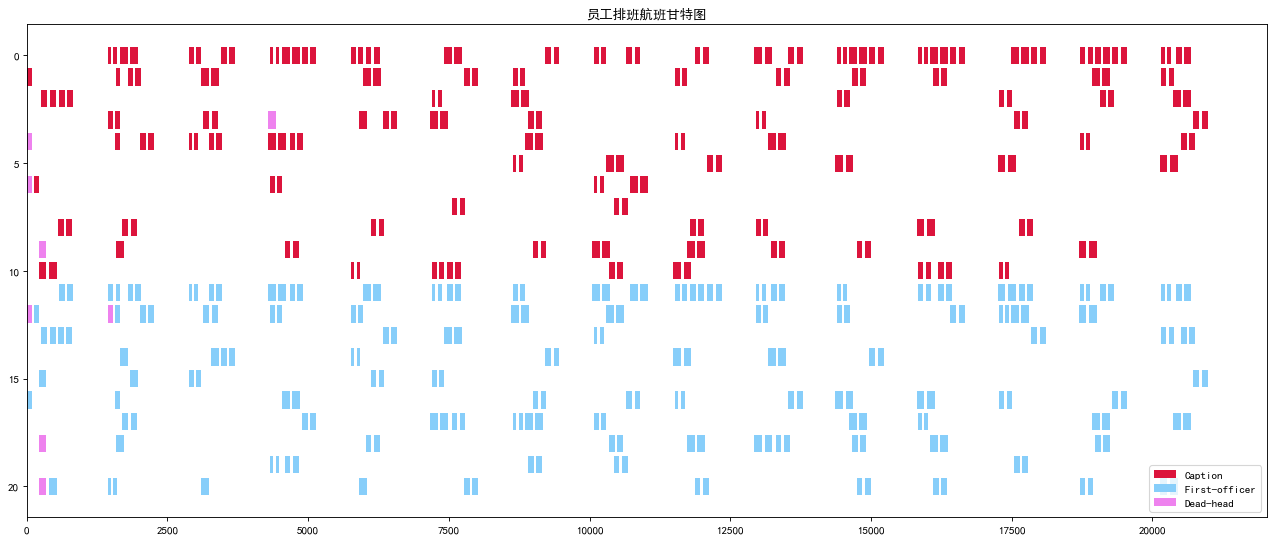

In [14]:
rv.draw_ef_gantt(save="results/q1_a.png")

In [ ]:
df_a = rv.get_results_df_a()

In [ ]:
df_a

In [ ]:
df_a.to_csv('results/q1_a_UnconveredFlights.csv', index=0)

In [ ]:
df_b = rv.get_results_df_b()
df_b

In [ ]:
df_b.to_csv('results/q1_a_CrewRosters.csv', index=0)

AttributeError: 'DataLoader' object has no attribute 'to_csv'